# Deep RL for time series playing idealized trading games

Applying the methodology from the Paper *Deep reinforcement learning for time series: playing idealized trading games* to the data set of this project.

First, here is the implementation from the orginal paper:

In [1]:
import random
import torch as T
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pandas as pd
import pickle
import os

import matplotlib.pyplot as plt
plt.style.use('seaborn-dark')

episode  0 score -132.21 average score -132.21 epsilon 0.99
episode  1 score -391.90 average score -262.05 epsilon 0.98
episode  2 score 152.83 average score -123.76 epsilon 0.96
episode  3 score 210.48 average score -40.20 epsilon 0.95
episode  4 score 239.38 average score 15.72 epsilon 0.94
episode  5 score -174.49 average score -15.98 epsilon 0.92
episode  6 score -74.61 average score -24.36 epsilon 0.91
episode  7 score -197.15 average score -45.96 epsilon 0.90
episode  8 score -18.34 average score -42.89 epsilon 0.88
episode  9 score 210.25 average score -17.57 epsilon 0.87


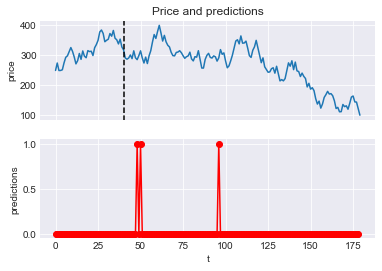

In [89]:
class Sampler:

	def load_db(self, fld):

		self.db = pickle.load(open(os.path.join(fld, 'db.pickle'),'rb'))
		param = json.load(open(os.path.join(fld, 'param.json'),'rb'))
		self.i_db = 0
		self.n_db = param['n_episodes']
		self.sample = self.__sample_db
		for attr in param:
			if hasattr(self, attr):
				setattr(self, attr, param[attr])
		self.title = 'DB_'+param['title']


	def build_db(self, n_episodes, fld):
		db = []
		for i in range(n_episodes):
			prices, title = self.sample()
			db.append((prices, '[%i]_'%i+title))
		os.makedirs(fld)	# don't overwrite existing fld
		pickle.dump(db, open(os.path.join(fld, 'db.pickle'),'wb'))
		param = {'n_episodes':n_episodes}
		for k in self.attrs:
			param[k] = getattr(self, k)
		json.dump(param, open(os.path.join(fld, 'param.json'),'w'))


	def __sample_db(self):
		prices, title = self.db[self.i_db]
		self.i_db += 1
		if self.i_db == self.n_db:
			self.i_db = 0
		return prices, title


class PairSampler(Sampler):

	def __init__(self, game,
		window_episode=None, forecast_horizon_range=None, max_change_perc=10., noise_level=10., n_section=1,
		fld=None, windows_transform=[]):

		self.window_episode = window_episode
		self.forecast_horizon_range = forecast_horizon_range
		self.max_change_perc = max_change_perc
		self.noise_level = noise_level
		self.n_section = n_section
		self.windows_transform = windows_transform
		self.n_var = 2 + len(self.windows_transform) # price, signal

		self.attrs = ['title', 'window_episode', 'forecast_horizon_range', 
			'max_change_perc', 'noise_level', 'n_section', 'n_var']
		param_str = str((self.noise_level, self.forecast_horizon_range, self.n_section, self.windows_transform))

		if game == 'load':
			self.load_db(fld)
		elif game in ['randwalk','randjump']:
			self.__rand = getattr(self, '_PairSampler__'+game)
			self.sample = self.__sample
			self.title = game + param_str
		else:
			raise ValueError


	def __randwalk(self, l):
		change = (np.random.random(l + self.forecast_horizon_range[1]) - 0.5) * 2 * self.max_change_perc/100
		forecast_horizon = random.randrange(self.forecast_horizon_range[0], self.forecast_horizon_range[1])
		return change[:l], change[forecast_horizon: forecast_horizon + l], forecast_horizon


	def __randjump(self, l):
		change = [0.] * (l + self.forecast_horizon_range[1])
		n_jump = random.randrange(15,30)
		for i in range(n_jump):
			t = random.randrange(len(change))
			change[t] = (np.random.random() - 0.5) * 2 * self.max_change_perc/100
		forecast_horizon = random.randrange(self.forecast_horizon_range[0], self.forecast_horizon_range[1])
		return change[:l], change[forecast_horizon: forecast_horizon + l], forecast_horizon



	def __sample(self):

		L = self.window_episode
		if bool(self.windows_transform):
			L += max(self.windows_transform)
		l0 = L/self.n_section
		l1 = L

		d_price = []
		d_signal = []
		forecast_horizon = []

		for i in range(self.n_section):
			if i == self.n_section - 1:
				l = l1
			else:
				l = l0
				l1 -= l0
			d_price_i, d_signal_i, horizon_i = self.__rand(l)
			d_price = np.append(d_price, d_price_i)
			d_signal = np.append(d_signal, d_signal_i)
			forecast_horizon.append(horizon_i)

		price = 100. * (1. + np.cumsum(d_price))
		signal = 100. * (1. + np.cumsum(d_signal)) + \
				np.random.random(len(price)) * self.noise_level

		price += (100 - min(price))
		signal += (100 - min(signal))

		inputs = [price[-self.window_episode:], signal[-self.window_episode:]]
		for w in self.windows_transform:
			inputs.append(signal[-self.window_episode - w: -w])

		return np.array(inputs).T, 'forecast_horizon='+str(forecast_horizon)


def get_PairSampleDf(size_time_series):
	fhr = (10,30)
	n_section = 1
	max_change_perc = 30.
	noise_level = 5
	game = 'randwalk'
	windows_transform = []

	sampler = PairSampler(game, window_episode=size_time_series, forecast_horizon_range=fhr, 
		n_section=n_section, noise_level=noise_level, max_change_perc=max_change_perc, windows_transform=windows_transform)   
    
	x = sampler.sample()[0]  
        
	price = x[:, 0]
	signal = x[:, 1]    
	df = pd.DataFrame({'y': price, 'signal': signal})
    
	return df


class DeepQNetwork(nn.Module):
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, 
            n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(*self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)

        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = T.device('cuda:0' if T.cuda.is_available() else 'cpu')
        self.to(self.device)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        actions = self.fc3(x)

        return actions


class Agent():
    def __init__(self, gamma, epsilon, lr, input_dims, batch_size, n_actions,
            max_mem_size=100000, eps_end=0.05, eps_dec=5e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.eps_min = eps_end
        self.eps_dec = eps_dec
        self.lr = lr
        self.action_space = [i for i in range(n_actions)]
        self.mem_size = max_mem_size
        self.batch_size = batch_size
        self.mem_cntr = 0
        self.iter_cntr = 0
        self.replace_target = 100

        self.Q_eval = DeepQNetwork(lr, n_actions=n_actions, input_dims=input_dims,
                                    fc1_dims=64, fc2_dims=32)

        self.state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.new_state_memory = np.zeros((self.mem_size, *input_dims), dtype=np.float32)
        self.action_memory = np.zeros(self.mem_size, dtype=np.int32)
        self.reward_memory = np.zeros(self.mem_size, dtype=np.float32)
        self.terminal_memory = np.zeros(self.mem_size, dtype=np.bool)

    def store_transition(self, state, action, reward, state_, terminal):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.new_state_memory[index] = state_
        self.reward_memory[index] = reward
        self.action_memory[index] = action
        self.terminal_memory[index] = terminal

        self.mem_cntr += 1
        
    def get_q_valid(self, q, valid_actions):
        q_valid = [np.nan] * len(q)
        for action in valid_actions:
            q_valid[action] = q[action]
        
        return q_valid

    def choose_action(self, observation, valid_actions):
        if np.random.random() > self.epsilon:
            state = T.tensor([observation], dtype=T.float32).to(self.Q_eval.device)
            q = self.Q_eval.forward(state)
            q = q.detach().numpy().squeeze()
            q = self.get_q_valid(q, valid_actions)
            action = np.nanargmax(q)
        else:
            action = np.random.choice(valid_actions)

        return action

    def learn(self):
        if self.mem_cntr < self.batch_size:
            return

        self.Q_eval.optimizer.zero_grad()

        max_mem = min(self.mem_cntr, self.mem_size)

        batch = np.random.choice(max_mem, self.batch_size, replace=False)

        batch_index = np.arange(self.batch_size, dtype=np.int32)

        state_batch = T.tensor(self.state_memory[batch]).to(self.Q_eval.device)
        new_state_batch = T.tensor(self.new_state_memory[batch]).to(self.Q_eval.device)
        action_batch = self.action_memory[batch]
        reward_batch = T.tensor(self.reward_memory[batch]).to(self.Q_eval.device)
        terminal_batch = T.tensor(self.terminal_memory[batch]).to(self.Q_eval.device)

        q_eval = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(new_state_batch)
        q_next[terminal_batch] = 0.0

        q_target = reward_batch + self.gamma*T.max(q_next,dim=1)[0]

        loss = self.Q_eval.loss(q_target, q_eval).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.iter_cntr += 1
        self.epsilon = self.epsilon - self.eps_dec if self.epsilon > self.eps_min \
                       else self.eps_min



class Environment():
    
    
    def __init__(self, n_games, window_size_observation, size_time_series):
        self.name = 'gao'
        self.n_games = n_games
        self.window_size_observation = window_size_observation 
        self.size_time_series = size_time_series
        self.current_game = 0
        self.t_current = 0
        self.empty = True
        self.open_cost = 0
        
        self.list_of_games = self.get_list_of_games()
        self.t_max = self.size_time_series - self.window_size_observation - 1

      
    def get_status_emtpy(self):
        return self.empty

    
    def get_current_df(self):
        return self.list_of_games[self.current_game]

        
    def get_list_of_games(self):
        list_of_games = []
        
        for i in range(self.n_games):
            list_of_games.append(get_PairSampleDf(size_time_series))
                   
        return list_of_games
    
    
    def reset(self):
        if self.current_game == self.n_games - 1:
            self.current_game = 0
        else:
            self.current_game += 1
            
        self.t_current = 0
        
        observation = self.get_observation()
        
        return observation
        
    
    def step(self, action):
        
        done = False
        if action == 0:		# wait/close
            reward = 0.
            self.empty = True
        elif action == 1:	# open
            reward = self.get_reward_noncash()
            self.empty = False
        elif action == 2:	# keep
            reward = self.get_reward_noncash()
        else:
            raise ValueError('no valid action: ' + str(action))
        
        self.t_current += 1
        #return self.get_state(), reward, self.t == self.t_max, self.get_valid_actions()
        
        
        done = self.t_current == self.t_max
        observation = self.get_observation()
        info = self.get_valid_actions()
        
        return observation, reward, done, info
 
    
    def get_reward_noncash(self):
        df_current = self.list_of_games[self.current_game]
               
        t_1 = self.t_current + self.window_size_observation + 1
        t = self.t_current + self.window_size_observation 
        
        price_t_1 = df_current.iloc[t_1, 0]
        price_t = df_current.iloc[t, 0]
        
        reward = price_t_1 - price_t
        
        if self.empty:
            reward -= self.open_cost
        
        return reward 
       
    
    
    def get_observation(self):
        df_current = self.list_of_games[self.current_game]
        
        observation = df_current.iloc[self.t_current:(self.t_current + self.window_size_observation), :]
        
        return observation
    
    
    def get_valid_actions(self):
        if self.empty:
            return [0, 1]	# wait, open
        else:
            return [0, 2]	# close, keep       
  
        
    def render(self):
        pass

    

def get_prediction(action, empty_status):
    # Determines prediction on a given empty_status and action
    # if empty, i. e. no stock is in depot, if action == 1 (buying) you bet on rising price
    # if not empty, i. e. stock is in depot, if action == 0 (selling) you bet on falling price
    
    if empty_status:
        if action == 1:
            return 1
        return -1
    else:
        if action == 0:
            return -1
        return 1
    
    
    
if __name__ == '__main__':
    n_games = 10
    window_size_observation = 40
    size_time_series = 180
    
    
    agent = Agent(gamma=0.8, epsilon=1, batch_size=64, n_actions=3, eps_end=0.01, 
                  input_dims=[window_size_observation], lr=0.001, eps_dec=1e-4)
    
    env = Environment(n_games, window_size_observation, size_time_series)
    
    scores, eps_history = [], []

    for i in range(n_games):
        score = 0
        done = False
        
        observation = env.reset()
        valid_actions = [0, 1]
        
        # take only signal as observation for now: 
        observation = observation.iloc[:, 1:].values.squeeze()
        
        while not done:
            action = agent.choose_action(observation, valid_actions)
            observation_, reward, done, valid_actions = env.step(action)
            
                
            # take only signal as observation for now: 
            observation_ = observation_.iloc[:, 1:].values.squeeze()
            
            score += reward
            agent.store_transition(observation, action, reward, 
                                    observation_, done)
            agent.learn()
            observation = observation_
        
        scores.append(score)
        eps_history.append(agent.epsilon)

        avg_score = np.mean(scores[-100:])

        print('episode ', i, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)
            
        
        
# =============================================================================
#     # Evaluation 
# =============================================================================
    n_games = 1
    env = Environment(n_games, window_size_observation, size_time_series)
    agent.epsilon = 0
    
    actions, empty_status, rewards = [], [], []

    for i in range(n_games):
        score = 0
        done = False
        
        observation = env.reset()
        valid_actions = [0, 1]
        
        # take only signal as observation for now: 
        observation = observation.iloc[:, 1:].values.squeeze()
        
        while not done:
            action = agent.choose_action(observation, valid_actions)
            observation_, reward, done, valid_actions = env.step(action)
            
                
            # take only signal as observation for now: 
            observation_ = observation_.iloc[:, 1:].values.squeeze()
            
            score += reward
            observation = observation_
            
            
            empty_status.append(env.get_status_emtpy())
            actions.append(action)
            rewards.append(reward)
            

    
        df = env.get_current_df()
        predictions = [get_prediction(action, empty_status) for action, empty in zip(actions, empty_status)]
        
        predictions = [0 for i in range(window_size_observation)] + predictions
        rewards = [0 for i in range(window_size_observation)] + rewards
        actions = [0 for i in range(window_size_observation)] + actions
        
     
       
        
               
        fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)

    
        ax.plot(df['y'], label='price')
        ax.axvline(x=window_size_observation, ymin=-100, ymax=500, color='black',linestyle='--', alpha=1)
        ax.grid()
        ax.set_ylabel('price') 
        ax.set_title("Price and predictions")
        
        
            
        ax2.plot(actions, 'ro-')
        ax2.set_xlabel('t') 
        ax2.set_ylabel('predictions') 
        
        
        
        plt.grid()
           
        plt.show()

    


Loading data:

In [3]:
database_dir = os.path.join(r'C:/Users/hauer/Documents/Repositories/cfds_project', 'database.pickle')

with open(database_dir,'rb') as f: 
    db = pickle.load(f)
    
database_training = db['database_training']
database_validation = db['database_validation']
database_test = db['database_test']

database_training_sv = db['database_training_sv']
database_validation_sv = db['database_validation_sv']
database_test_sv = db['database_test_sv']

database_training_sv_standard = db['database_training_sv_standard']
database_validation_sv_standard = db['database_validation_sv_standard']
database_test_sv_standard = db['database_test_sv_standard']

database_scaler = db['database_scaler']

As we only have limited amout of data, i define the parameter `n_games` as the number of epochs. So for every game, each country is sampled.

In [119]:
class Environment():
    
    
    def __init__(self, n_epochs, window_size_observation, size_time_series):
        self.name = 'gao'
        self.n_epochs = n_epochs
        self.window_size_observation = window_size_observation 
        self.size_time_series = size_time_series
        self.current_game = 0
        self.t_current = 0
        self.empty = True
        self.open_cost = 0
        
        self.list_of_games = self.get_list_of_games()
        self.n_games = len(self.list_of_games)
        self.t_max = self.size_time_series - self.window_size_observation - 1

      
    def get_status_emtpy(self):
        return self.empty

    
    def get_current_df(self):
        return self.list_of_games[self.current_game]

        
    def get_list_of_games(self):
        list_of_games = []
        
        for i in range(self.n_epochs):
            for country in database_training_sv_standard.keys():
                list_of_games.append(database_training_sv_standard[country])
                   
        return list_of_games
    
    
    def reset(self):
        if self.current_game == self.n_games - 1:
            self.current_game = 0
        else:
            self.current_game += 1
            
        self.t_current = 0
        
        observation = self.get_observation()
        
        return observation
        
    
    def step(self, action):
        
        done = False
        if action == 0:		# wait/close
            reward = 0.
            self.empty = True
        elif action == 1:	# open
            reward = self.get_reward_noncash()
            self.empty = False
        elif action == 2:	# keep
            reward = self.get_reward_noncash()
        else:
            raise ValueError('no valid action: ' + str(action))
        
        self.t_current += 1
        #return self.get_state(), reward, self.t == self.t_max, self.get_valid_actions()
        
        
        done = self.t_current == self.t_max
        observation = self.get_observation()
        info = self.get_valid_actions()
        
        return observation, reward, done, info
 
    
    def get_reward_noncash(self):
        df_current = self.list_of_games[self.current_game]
               
        t_1 = self.t_current + self.window_size_observation + 1
        t = self.t_current + self.window_size_observation 

        price_t_1 = df_current.iloc[t_1, 0]
        price_t = df_current.iloc[t, 0]
        
        reward = price_t_1 - price_t
        
        if self.empty:
            reward -= self.open_cost
        
        return reward 
       
    
    
    def get_observation(self):
        df_current = self.list_of_games[self.current_game]
        
        observation = df_current.iloc[self.t_current:(self.t_current + self.window_size_observation), :]
        
        return observation
    
    
    def get_valid_actions(self):
        if self.empty:
            return [0, 1]	# wait, open
        else:
            return [0, 2]	# close, keep       
  
        
    def render(self):
        pass

In [135]:
N, p = database_training_sv_standard['Germany'].shape


n_epochs = 50
window_size_observation = 15
size_time_series = N


agent = Agent(gamma=0.8, epsilon=1, batch_size=64, n_actions=3, eps_end=0.01, 
              input_dims=[window_size_observation * p], lr=0.001, eps_dec=1e-4)

env = Environment(n_epochs, window_size_observation, size_time_series)
n_games = env.n_games

n_countries = len(database_training_sv_standard.keys())

scores, eps_history = [], []

for i in range(n_games):
    score = 0
    done = False

    observation = env.reset()
    valid_actions = [0, 1]

    # take only signal as observation for now: 
    #observation = observation.iloc[:, 1:].values.squeeze()
    observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

    while not done:
        action = agent.choose_action(observation, valid_actions)
        observation_, reward, done, valid_actions = env.step(action)


        # take only signal as observation for now: 
        #observation_ = observation_.iloc[:, 1:].values.squeeze()
        observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

        score += reward
        agent.store_transition(observation, action, reward, 
                                observation_, done)
        agent.learn()
        observation = observation_

    scores.append(score)
    eps_history.append(agent.epsilon)

    avg_score = np.mean(scores[-100:])
    
    if i % n_countries == 0:
        print('episode ', i / n_countries, 'score %.2f' % score,
                'average score %.2f' % avg_score,
                'epsilon %.2f' % agent.epsilon)

episode  0.0 score -0.08 average score -0.08 epsilon 1.00
episode  1.0 score 5.33 average score 0.15 epsilon 0.95
episode  2.0 score 5.38 average score 0.25 epsilon 0.90
episode  3.0 score 5.38 average score 0.58 epsilon 0.84
episode  4.0 score 0.02 average score 0.62 epsilon 0.79
episode  5.0 score -5.40 average score 0.50 epsilon 0.74
episode  6.0 score 5.33 average score 0.46 epsilon 0.68
episode  7.0 score 5.36 average score 0.67 epsilon 0.63
episode  8.0 score 5.38 average score 1.03 epsilon 0.57
episode  9.0 score 5.37 average score 1.24 epsilon 0.52
episode  10.0 score 5.31 average score 1.12 epsilon 0.47
episode  11.0 score 5.40 average score 1.28 epsilon 0.41
episode  12.0 score 5.35 average score 1.44 epsilon 0.36
episode  13.0 score 5.39 average score 1.74 epsilon 0.30
episode  14.0 score 5.41 average score 1.91 epsilon 0.25
episode  15.0 score 0.05 average score 2.01 epsilon 0.20
episode  16.0 score 5.42 average score 2.31 epsilon 0.14
episode  17.0 score 5.40 average score

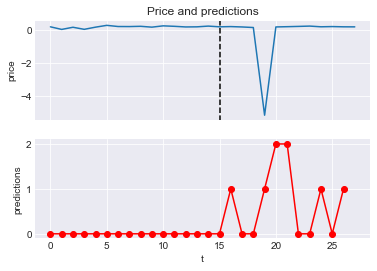

In [136]:
# =============================================================================
#     # Evaluation 
# =============================================================================
n_games = 1
env = Environment(n_games, window_size_observation, size_time_series)
agent.epsilon = 0

actions, empty_status, rewards = [], [], []

for i in range(n_games):
    score = 0
    done = False

    observation = env.reset()
    valid_actions = [0, 1]

    # take only signal as observation for now: 
    observation= np.squeeze(observation.values.transpose().reshape((1, -1)))

    while not done:
        action = agent.choose_action(observation, valid_actions)
        observation_, reward, done, valid_actions = env.step(action)


        # take only signal as observation for now: 
        observation_= np.squeeze(observation_.values.transpose().reshape((1, -1)))

        score += reward
        observation = observation_


        empty_status.append(env.get_status_emtpy())
        actions.append(action)
        rewards.append(reward)



    df = env.get_current_df()
    predictions = [get_prediction(action, empty_status) for action, empty in zip(actions, empty_status)]

    predictions = [0 for i in range(window_size_observation)] + predictions
    rewards = [0 for i in range(window_size_observation)] + rewards
    actions = [0 for i in range(window_size_observation)] + actions





fig, (ax, ax2) = plt.subplots(2, 1, sharex=True)


ax.plot(df.iloc[:,0], label='price')
ax.axvline(x=window_size_observation, ymin=-100, ymax=500, color='black',linestyle='--', alpha=1)
ax.grid()
ax.set_ylabel('price') 
ax.set_title("Price and predictions")



ax2.plot(actions, 'ro-')
ax2.set_xlabel('t') 
ax2.set_ylabel('predictions') 



plt.grid()

plt.show()

In [133]:
df

,0,1,2,3,4,5,6
0,0.194608,-1.104198,0.194946,1.242379,0.254439,-2.404193,-0.418438
1,0.036057,2.168738,0.193002,2.596325,0.254439,-0.330528,-0.418438
2,0.167112,-0.464300,0.237910,0.911520,0.254439,0.441595,-0.418438
3,0.041370,0.983765,0.199349,3.043675,0.254439,-1.081534,-0.418438
4,0.173348,-0.712099,0.199476,0.602374,0.254439,-0.330528,-3.874359
5,0.283476,0.165532,0.190430,0.211826,0.254439,-0.330528,1.840190
6,0.212700,-0.439609,0.181429,0.080110,0.254439,1.912641,1.415023
7,0.209593,0.412514,0.258313,-0.096103,0.254439,2.173717,0.466911
8,0.225174,0.961515,0.194173,0.243197,0.262044,-0.883259,1.369731
9,0.173919,-0.207605,0.178228,0.263407,0.223564,-0.908699,1.408725


In [105]:
observation = env.reset()
observation.shape

(10, 7)

In [106]:
observation


,0,1,2,3,4,5,6
0,0.145138,0.141260,-0.089353,0.863760,0.052708,-1.327333,-0.556629
1,-5.161730,0.089750,0.170742,0.657399,0.081044,0.850146,-0.179274
2,-0.054371,0.116412,0.298983,1.249568,0.141361,1.478550,-0.606784
3,0.272941,0.150485,0.276049,0.485217,0.197942,0.840167,-0.126581
4,0.199344,-0.117096,0.243664,-2.680870,0.015720,0.837769,1.564893
5,0.223438,-5.129783,0.186455,-1.656897,0.214042,-0.084021,-0.262884
6,0.186586,0.777114,0.210589,-0.082920,-0.089448,0.218883,-0.790308
7,0.319337,0.405338,0.202944,0.833106,0.142536,-0.732531,-0.123222
8,0.219433,0.173185,0.160088,-1.310800,0.281054,-1.103466,0.451506
9,0.248879,0.243863,0.027862,0.413634,0.322594,-0.487466,0.492113


In [107]:
np.squeeze(observation.values.transpose().reshape((1, -1)))

array([ 0.14513779, -5.16173026, -0.05437099,  0.27294056,  0.19934419,
        0.22343753,  0.18658642,  0.31933725,  0.21943287,  0.24887888,
        0.14126047,  0.08975039,  0.1164115 ,  0.15048505, -0.1170958 ,
       -5.12978292,  0.77711427,  0.405338  ,  0.17318525,  0.24386284,
       -0.08935298,  0.17074177,  0.29898334,  0.27604853,  0.24366365,
        0.18645484,  0.21058934,  0.20294409,  0.16008772,  0.02786236,
        0.86375955,  0.65739912,  1.24956822,  0.48521716, -2.68086993,
       -1.65689726, -0.08291977,  0.833106  , -1.31080019,  0.41363408,
        0.05270823,  0.08104362,  0.1413608 ,  0.19794227,  0.01571989,
        0.21404183, -0.08944818,  0.14253561,  0.28105356,  0.32259418,
       -1.3273334 ,  0.85014645,  1.47855037,  0.84016689,  0.83776851,
       -0.08402118,  0.2188833 , -0.73253144, -1.1034665 , -0.48746615,
       -0.55662865, -0.17927384, -0.60678422, -0.12658138,  1.56489334,
       -0.26288427, -0.79030757, -0.12322189,  0.45150556,  0.49

In [90]:
observation

array([217.20804844, 218.54162636, 211.47856944, 197.07798998,
       170.21254528, 171.00406702, 157.82256396, 159.3307305 ,
       183.07878345, 173.29575814, 177.29762565, 169.08630087,
       186.9458418 , 207.45805217, 211.40259661, 190.77158568,
       192.84575375, 167.00758405, 146.76272528, 146.67196303,
       145.95087316, 156.79445887, 173.92535055, 198.85993952,
       204.5088348 , 190.79894028, 171.49738767, 164.80551302,
       160.6015836 , 164.24561908, 164.58762521, 161.13433576,
       145.63949618, 122.45601694, 100.        , 111.08950074,
       115.0039518 , 112.78813106, 128.23663868, 136.40012888])

In [123]:
n_games

45